In [68]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
import gc
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf

# from pylorentz import Momentum4
# from mt2 import mt2

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [69]:
seed = 42  # set random seed
sampling = int(1e5)
# num_folds = 2
batch_size = 1024
epochs = 512
learning_rate = 1e-5

In [70]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [71]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [72]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)
lep_m = processor.process_part(data.LepM)
lep_kin = pd.concat([lep_p.iloc[:,:4], lep_m.iloc[:,:4]], axis=1)
MET = processor.process_MET(data.MET)
dilep_kin = processor.process_dipart(data.LepP, data.LepM)
# mt2 = np.sqrt(
#     mt2(
#         lep_m["m"],
#         lep_m["px"],
#         lep_m["py"],  # Visible 1: mass, px, py
#         lep_p["m"],
#         lep_p["px"],
#         lep_p["py"],  # Visible 2: mass, px, py
#         MET["MET_px"],
#         MET["MET_py"],  # Missing transverse momentum: x, y
#         0,
#         0,  # Invisible 1 mass, invisible 2 mass
#     )
# )
# vx = 5 * pd.DataFrame({"vx": mt2 + 0.3 * np.sqrt(dilep_kin["m"])})
# dilep_kin.iloc[:, 0:4]
mask = ~processor.process_dipart(data.NuP, data.NuM)[["E"]].isna().values.reshape(-1) * cut_pre
obs_kin = pd.concat([MET.iloc[:, 1:3], lep_kin], axis=1)[mask]
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(processor.process_dipart(data.NuP, data.NuM)[["E"]])[mask]
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

# del (processor, lep_p, lep_m, MET, dilep_kin, mt, vx)
# gc.collect()

/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3978/1085300634.py:23: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask = ~processor.process_dipart(data.NuP, data.NuM)[["E"]].isna().values.reshape(-1) * cut_pre


obs_kin shape: (1378510, 10)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

int_kin shape: (1378510, 1)
             E
7   153.433431
9   187.088398
10  105.357433



/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


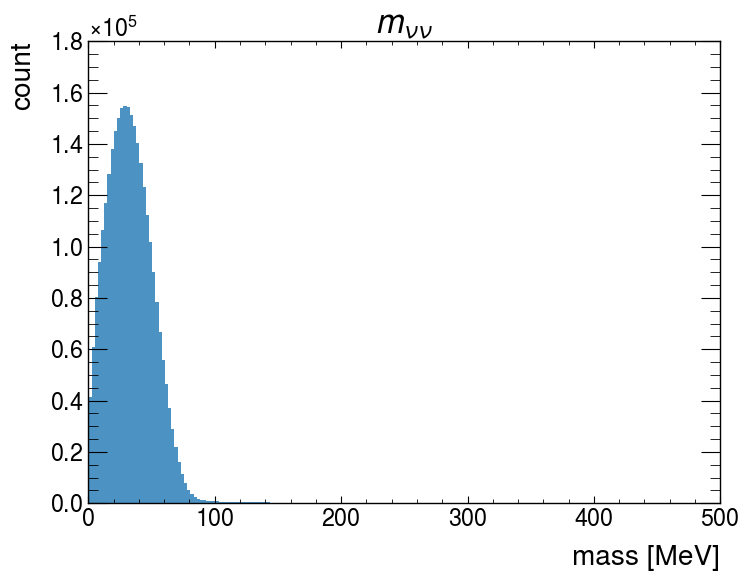

/root/miniconda3/envs/tf/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


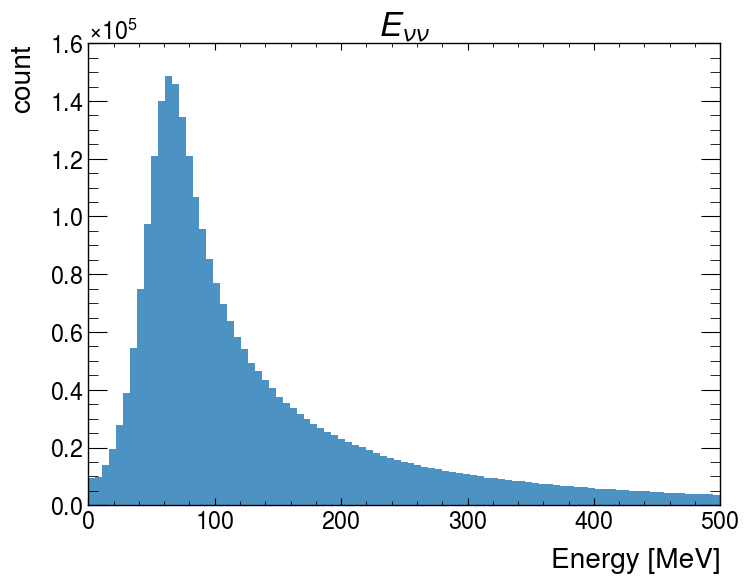

In [73]:
from matplotlib import pyplot as plt

plt.hist(processor.process_dipart(data.NuP, data.NuM)[["m"]], bins=800, alpha=.8)
plt.title(r"$m_{\nu\nu}$")
plt.xlabel("mass [MeV]")
plt.ylabel("count")
plt.xlim([0,500])
plt.show()

plt.hist(processor.process_dipart(data.NuP, data.NuM)[["E"]], bins=800, alpha=.8)
plt.title(r"$E_{\nu\nu}$")
plt.xlabel("Energy [MeV]")
plt.ylabel("count")
plt.xlim([0,500])
plt.show()

In [74]:
SCALAR_int_ru = RobustScaler()
int_kin = SCALAR_int_ru.fit_transform(int_kin)
# SCALAR_int_mm = MinMaxScaler()
# int_kin = SCALAR_int_mm.fit_transform(int_kin)

SCALAR_obs_ru = RobustScaler()
obs_kin = SCALAR_obs_ru.fit_transform(obs_kin)
# SCALAR_obs_mm = MinMaxScaler()
# obs_kin = SCALAR_obs_mm.fit_transform(obs_kin)

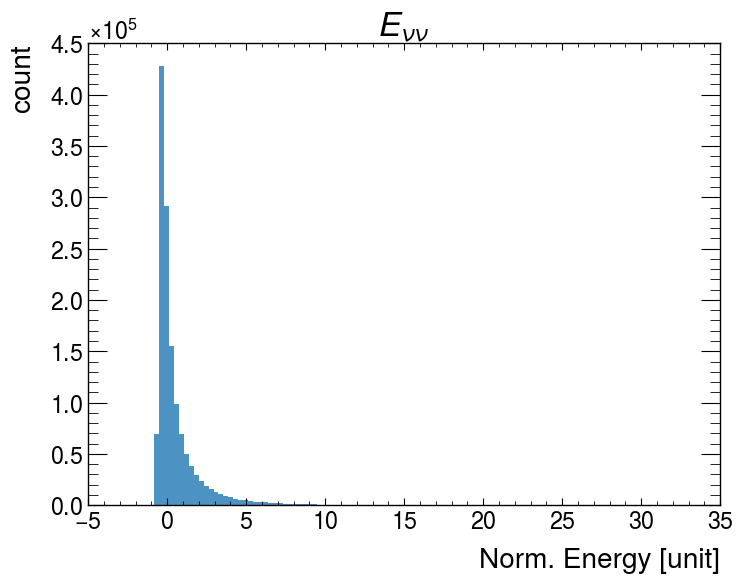

In [88]:
plt.hist(int_kin, bins=100, alpha=.8)
plt.title(r"$E_{\nu\nu}$")
plt.xlabel("Norm. Energy [unit]")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [59]:
indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.4,
    test_size=0.6,
    random_state=seed,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (551404, 10);
Validing data shape: (413553, 10);
Testing data shape: (413553, 10).
Y (Observed)
Training data shape: (551404, 1);
Validing data shape: (413553, 1);
Testing data shape: (413553, 1).



In [60]:
# # Define the generator function of the dataset.
# def data_gen(X_data, y_data, indices):
#     while True:
#         for start in range(0, len(indices), batch_size):
#             end = min(start + batch_size, len(indices))
#             # print(f"start: {start}, end: {end}, indices: {indices[start:end]}")
#             # print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")
#             yield X_data[indices[start:end]], y_data[indices[start:end]]

In [61]:
# Define a new activation function
def custom_activation(x):
    return x*tf.keras.backend.sigmoid(x)

# Define the model.
def build_model():
    # Input layer
    inputs = tf.keras.layers.Input(shape=(train_x.shape[-1],))
    x = tf.keras.layers.Flatten()(inputs)

    # Hidden tf.keras.layers
    x = tf.keras.layers.Dense(units=512, activation="elu")(x)
    x = tf.keras.layers.Dense(units=512, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    x = tf.keras.layers.Dense(units=32, activation="elu")(x)
    x = tf.keras.layers.Dense(units=32, activation="elu")(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    x = tf.keras.layers.Dense(units=4, activation="elu")(x)
    
    # Last dense layer
    outputs = tf.keras.layers.Dense(units=train_y.shape[-1], activation="sigmoid")(x)

    # Compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
    )

    # Summarize the model
    model.summary()

    return model

In [62]:
model = build_model()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 flatten_3 (Flatten)         (None, 10)                0         
                                                                 
 dense_17 (Dense)            (None, 512)               5632      
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 32)                16416     
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 4)                 132 

In [63]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(valid_x, valid_y),
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[stop_early],
)

Epoch 1/512
539/539 - 5s - loss: 0.0233 - val_loss: 0.0036 - 5s/epoch - 9ms/step
Epoch 2/512
539/539 - 3s - loss: 0.0030 - val_loss: 0.0028 - 3s/epoch - 5ms/step
Epoch 3/512
539/539 - 3s - loss: 0.0028 - val_loss: 0.0027 - 3s/epoch - 5ms/step
Epoch 4/512
539/539 - 3s - loss: 0.0027 - val_loss: 0.0027 - 3s/epoch - 5ms/step
Epoch 5/512
539/539 - 3s - loss: 0.0027 - val_loss: 0.0027 - 3s/epoch - 5ms/step
Epoch 6/512
539/539 - 3s - loss: 0.0027 - val_loss: 0.0026 - 3s/epoch - 5ms/step
Epoch 7/512
539/539 - 3s - loss: 0.0027 - val_loss: 0.0026 - 3s/epoch - 5ms/step
Epoch 8/512
539/539 - 3s - loss: 0.0026 - val_loss: 0.0025 - 3s/epoch - 5ms/step
Epoch 9/512
539/539 - 3s - loss: 0.0025 - val_loss: 0.0024 - 3s/epoch - 5ms/step
Epoch 10/512
539/539 - 3s - loss: 0.0024 - val_loss: 0.0023 - 3s/epoch - 5ms/step
Epoch 11/512
539/539 - 3s - loss: 0.0023 - val_loss: 0.0023 - 3s/epoch - 5ms/step
Epoch 12/512
539/539 - 3s - loss: 0.0023 - val_loss: 0.0023 - 3s/epoch - 5ms/step
Epoch 13/512
539/539 - 3s

In [64]:
# # Define per-fold score containers
# acc_per_fold = []
# loss_per_fold = []

# # Define the K-fold Cross Validator
# kfold = KFold(n_splits=num_folds, shuffle=True)

# # K-fold Cross Validation model evaluation
# fold_no = 1
# best_model = None
# best_loss = np.inf

# # Settting up early stopping callbacks
# stop_early = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=1e-4,
#     patience=10,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=True,
# )

# # Check and find the best model form k-fold cross validation (or detect wether it's overtrining or not).
# for train, valid in kfold.split(train_x, train_y):
#     # Define the model architecture
#     model = build_model()

#     # Generate a print
#     print(f"Training for fold {fold_no} ...")

#     # Fit the model
#     history = model.fit(
#         data_gen(train_x, train_y, train),
#         steps_per_epoch=len(train) // batch_size,
#         validation_data=data_gen(train_x, train_y, valid),
#         validation_steps=len(valid) // batch_size,
#         epochs=epochs,
#         verbose=0,
#         callbacks=[stop_early],
#     )

#     # Generate generalization metrics
#     scores = model.evaluate(train_x[valid], train_y[valid], verbose=0)
#     print(
#         f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%"
#     )
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])

#     # Check if this model is better than the previous best model
#     if scores[0] < best_loss:
#         best_loss = scores[0]
#         best_model = model
#         best_history = history

#     # Plotting training results
#     print(f"Plotting fold {fold_no} loss history...")
#     plot.plot_loss_history(history, logy=True)

#     # Increase fold number
#     fold_no = fold_no + 1

# # == Provide average scores ==
# best_model.summary()
# print(
#     f"""{'-'*72}
# Score per fold"""
# )
# for i in range(0, len(acc_per_fold)):
#     print(
#         f"""{'-'*72}
# > Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%"""
#     )
# print(
#     f"""{'-'*72}
# Average scores for all folds:
# > Accuracy: {np.mean(acc_per_fold)}% (+- {np.std(acc_per_fold)})
# > Loss: {np.mean(loss_per_fold)}
# {'-'*72}"""
# )

In [65]:
# save model
model.save("DNN_modified_e.h5", save_format="h5", overwrite=True)
# predict
pred_y = model.predict(test_x)
sig_pred = pred_y
sig_truth = test_y

    1/12924 [..............................] - ETA: 16:21

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12924/12924 [==============================] - 16s 1ms/step


In [66]:
print(f"Truth mean: {np.mean(sig_truth[:,0]):.3f}, std: {np.std(sig_truth[:,0]):.3f}")

Truth mean: 0.044, std: 0.052


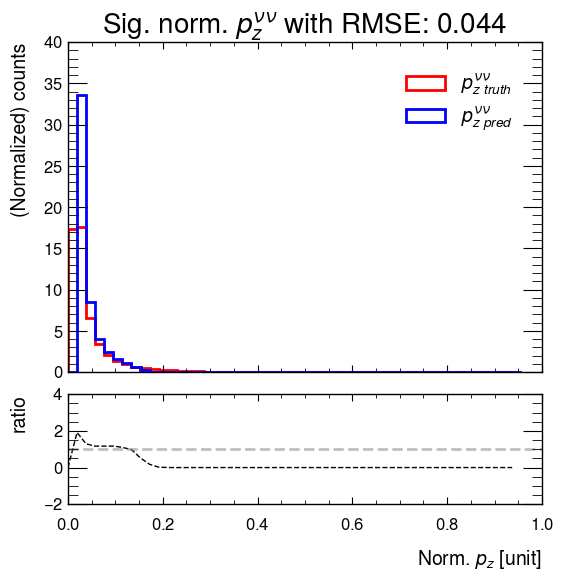

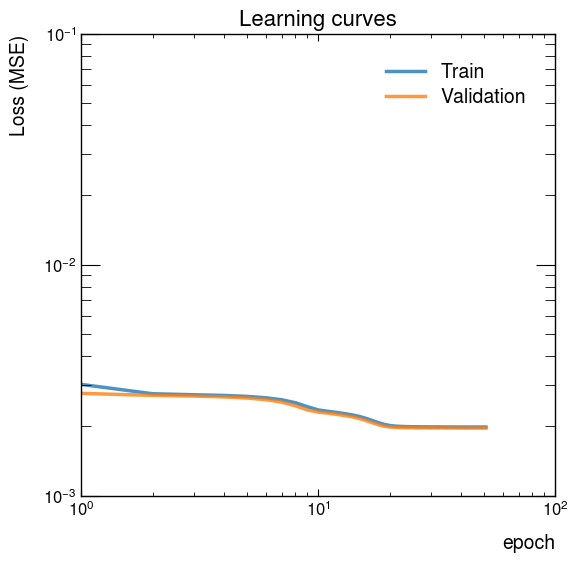

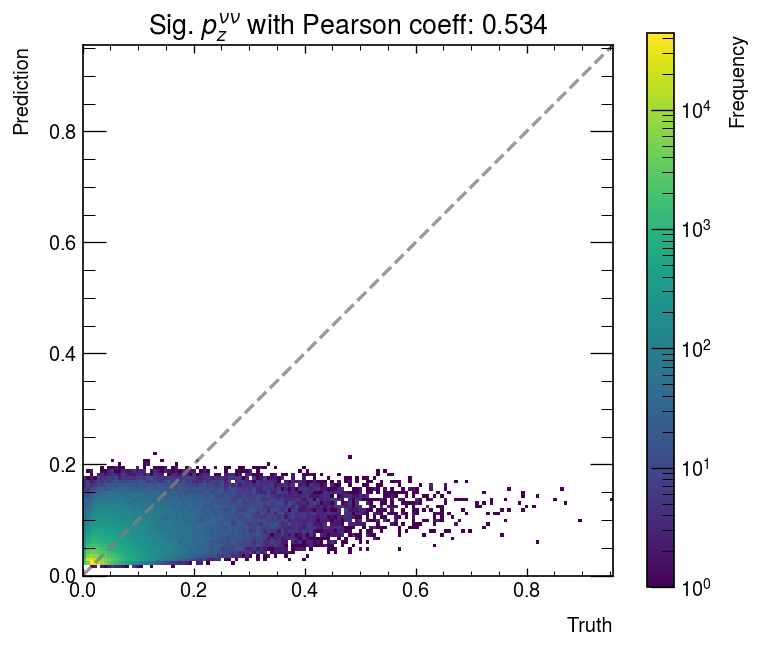

In [67]:
from sklearn.metrics import mean_squared_error

range = [0.43, 0.57]

plot.plot_hist(
    [sig_truth[:, 0], sig_pred[:, 0]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Sig. norm. $p^{\nu\nu}_{z}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
    # range=range,
    xlabel=r"Norm. $p_{z}$ [unit]",
)

plot.plot_loss_history(history, logx=True, logy=True)

plot.plot_2d_histogram(
    sig_truth[:, 0],
    sig_pred[:, 0],
    r"Sig. $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
    # range=range,
)

In [49]:
# from sklearn.metrics import mean_squared_error

# range = [0.43, 0.57]

# plot.plot_hist(
#     [sig_truth[:, 0], sig_pred[:, 0]],
#     [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
#     r"Sig. norm. $p^{\nu\nu}_{z}$" + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth[:,0], sig_pred[:,0])):.3f}",
#     range=range,
#     xlabel=r"[Norm. $p_{z}$ unit]",
# )

# plot.plot_loss_history(history, logx=True, logy=True)

# plot.plot_2d_histogram(
#     sig_truth[:, 0],
#     sig_pred[:, 0],
#     r"Sig. $p_{z}^{\nu\nu}$ "
#     + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,0], sig_pred[:,0])[0]:.3f}",
#     range=range,
# )

In [50]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10



KeyboardInterrupt: 

In [ ]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.NuP, data.NuM)[["pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

In [ ]:
# SCALAR_obs_std_bkg = StandardScaler()
# obs_kin = SCALAR_obs_std_bkg.fit_transform(obs_kin)
SCALAR_obs_qt_bkg = QuantileTransformer(output_distribution='normal')
obs_kin = SCALAR_obs_qt_bkg.fit_transform(obs_kin)

# SCALAR_int_std_bkg = StandardScaler()
# int_kin = SCALAR_int_std_bkg.fit_transform(int_kin)
SCALAR_int_qt_bkg = QuantileTransformer(output_distribution='normal')
int_kin = SCALAR_int_qt_bkg.fit_transform(int_kin)

x, y = obs_kin[indices_arr], int_kin[indices_arr]

print(f"X:\ndata shape: {x.shape};\nY:\ndata shape: {y.shape}.")
print()

In [ ]:
y_pred = model.predict(x)
bkg_pred = y_pred
bkg_truth = y

In [ ]:
range = [
    np.max([bkg_pred[:, 0].min(), bkg_truth[:, 0].min()]),
    np.min([bkg_pred[:, 0].max(), bkg_truth[:, 0].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

In [ ]:
range = [
    np.max([bkg_pred[:, 1].min(), bkg_truth[:, 1].min()]),
    np.min([bkg_pred[:, 1].max(), bkg_truth[:, 1].max()]),
]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")